In [58]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

from pvcracks.utils import viz_functions, train_functions

import io
from PIL import Image

from pvimage import features

## Step 1: Download Model

DOI - https://doi.org/10.21948/2997859  
Direct Link - https://datahub.duramat.org/dataset/24d7ed98-956e-4ebc-bf21-6584ecec2ff1/resource/e6d5dee2-0aef-439e-978c-d8c572e7039e/download/model.pt

## Step 2: Download and Load Images

DOI - https://doi.org/10.21948/2587738  
Direct Link - https://datahub.duramat.org/dataset/5e7587ad-6ad1-4d6f-8432-70940a6d7ca1/resource/8f12be45-b929-4f5c-9400-84dde27b0e90/download/labeledelcells.zip

## Step 3: Set local paths

In [59]:
files_root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty/"

weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty/checkpoints/Channeled_Combined_CWRU_LBNL_ASU_No_Empty10/epoch_19/model.pt"

## Step 4: Load in everything

In [60]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

root = Path(files_root)
img_root = root / "img" / "all"

train_dataset, val_dataset = train_functions.load_dataset(root)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
device, model = train_functions.load_device_and_model(
    category_mapping, existing_weight_path=weight_path
)

## Step 5: Pick image and threshold

Index is what image to run this model on.  

Threshold is what confidence % we want to code as an actual detection target, rather than just background noise.

In [61]:
idx = 0
threshold = 0.5 # default

## Step 6: Inference and Show

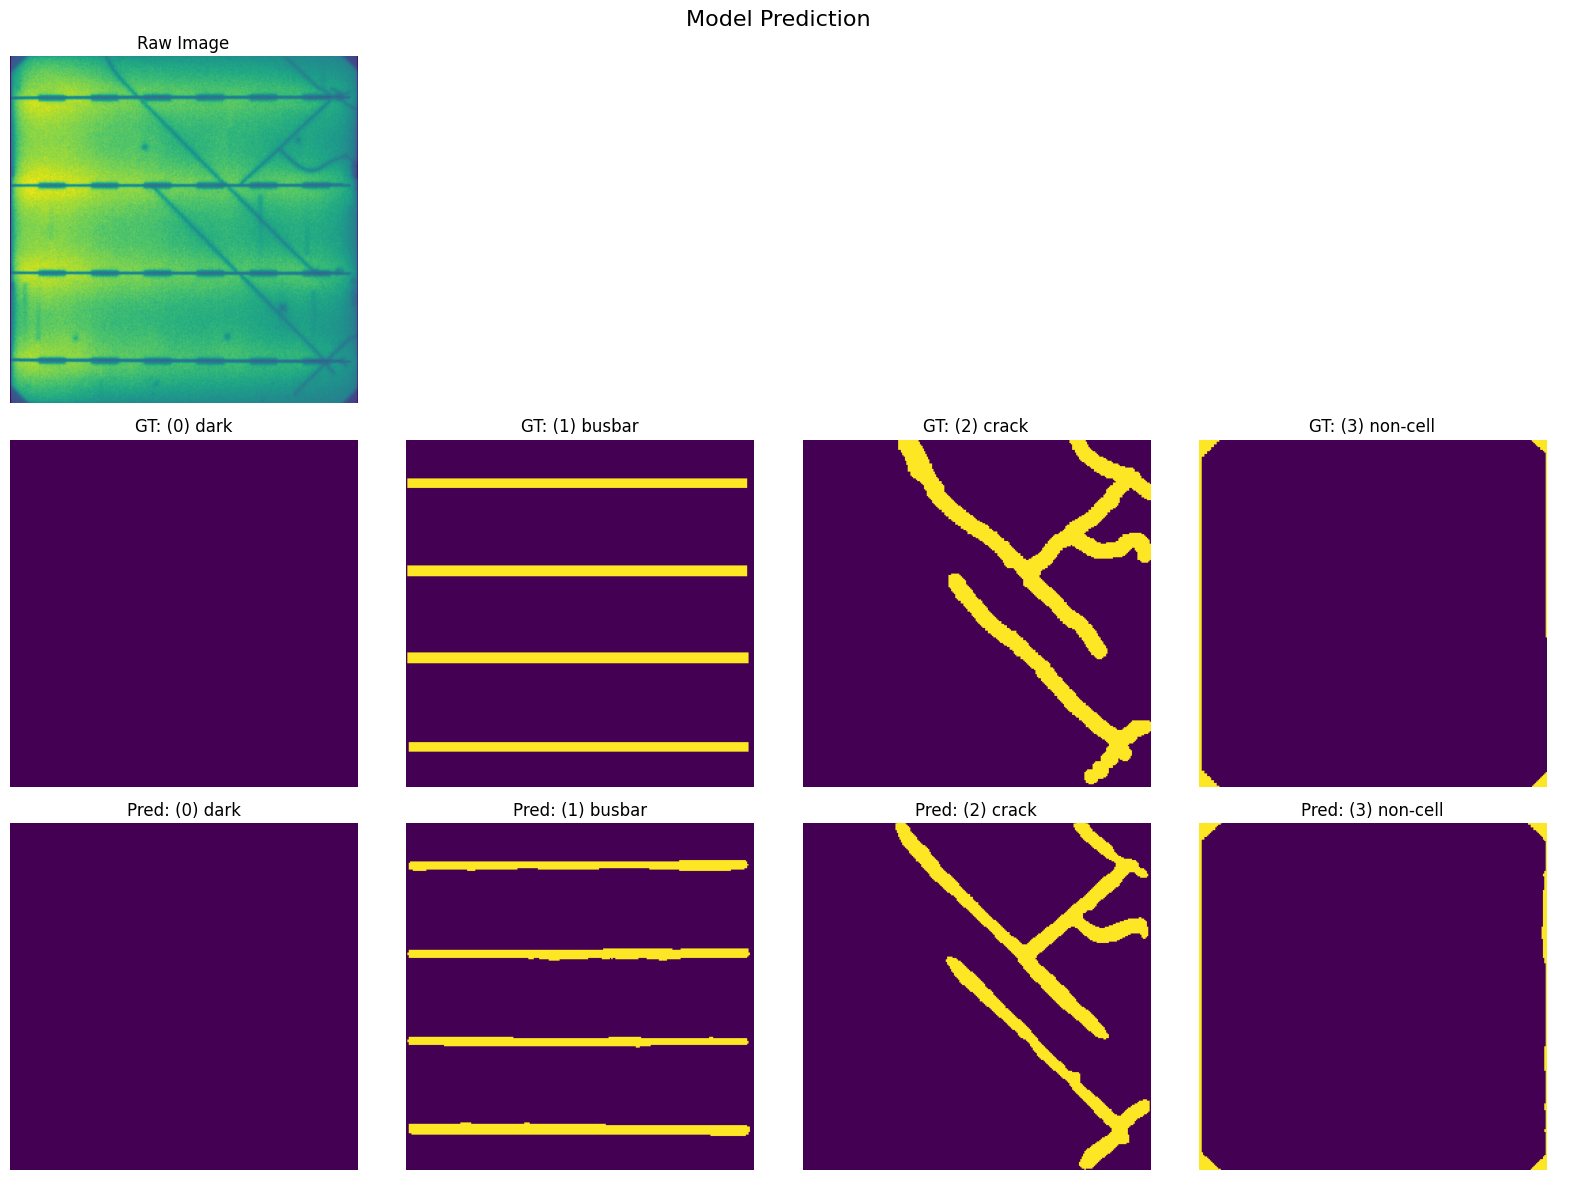

In [62]:
viz_functions.channeled_inference_and_show(
    val_loader, device, model, category_mapping, idx, threshold
)

## Step 7: Crack mask features with PVImage

Extract predicted crack masks, compute crack statistics with PVImage, and visualize the distribution of key metrics.


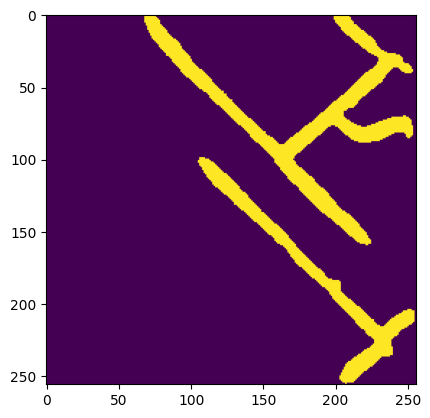

In [63]:
data_loader = val_loader  # for clarity

# Get the preprocessed image and multi-hot ground truth mask
img, mask = data_loader.dataset.__getitem__(idx)
img = img.to(device)
img_path = data_loader.dataset.__get_img_path__(idx)

# --- Run inference ---
# Get raw logits from the model, then apply Sigmoid and threshold
logits = model(img.unsqueeze(0)).detach().cpu()  # shape: [1, n_classes, H, W]
probs = torch.sigmoid(logits)  # shape: [1, n_classes, H, W]
pred_mask = (probs > threshold).float().squeeze(0).numpy()  # shape: [n_classes, H, W]

fig, ax = plt.subplots()

# Row 2: Predictions for each class (each channel)
ax.imshow(pred_mask[2], cmap="viridis")

# Save to memory buffer
buf = io.BytesIO()
fig.savefig(buf, format="png")
buf.seek(0)  # Rewind the buffer to the beginning

# Now you can open it as an image (e.g., with Pillow)
my_new_img = Image.open(buf)

In [64]:
crack_mask = (pred_mask[2] * 255).astype(np.uint8)  # Convert [0,1] to [0,255]

# Create DataFrame with image path
dfinfo = pd.DataFrame()
dfinfo["impath"] = [str(img_path)]  # Wrap in list

# Run feature extraction
dffeaturesreal = features.feature_extraction_crack_mask([crack_mask], dfinfo)
dffeaturesreal.head()

,cell_number,i,prop.perimeter,slope,prop.convex_area,prop.area,prop.orientation
0,mxy_sa19965_sub_EL_9,2,271.740115,-0.298467,2296.0,1497.0,-0.486834
0,mxy_sa19965_sub_EL_9,8,266.468037,-0.155785,1826.0,1403.0,-0.386939
0,mxy_sa19965_sub_EL_9,4,235.39697,-1.476617,2109.0,1289.0,-1.394845
0,mxy_sa19965_sub_EL_9,5,233.39697,0.500036,2353.0,1422.0,0.739917


In [65]:
def violinplt(data, palette=None, figsize=(5, 4)):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Coerce to DataFrame so .mean() and column names behave
    if isinstance(data, pd.Series):
        data = data.to_frame()
    elif not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    fig, ax = plt.subplots(figsize=figsize)

    # Seaborn API: no widths/showmeans/showmedians/showextrema here
    # Use inner="quartile" to show quartiles; cut=0 to avoid extrapolation
    sns.violinplot(
        data=data,
        ax=ax,
        palette=palette,
        inner="quartile",
        cut=0,
        linewidth=1,
    )

    # Overlay means as points
    means = data.mean().to_numpy()
    x_pos = np.arange(len(means))
    ax.scatter(x_pos, means, zorder=3)

    # Prepare mean labels
    nobs = [f"{m:.2f}" for m in means]

    # Place mean labels slightly above the point
    y_offset = 0.03 * (
        np.nanmax(means) - np.nanmin(means) if np.all(np.isfinite(means)) else 1.0
    )
    if len(x_pos) > 3:
        for i in x_pos:
            t = ax.text(
                i,
                means[i] + y_offset,
                nobs[i],
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
                weight="semibold",
            )
            # subtle white box for readability
            t.set_bbox(
                dict(
                    facecolor="white",
                    alpha=0.5,
                    edgecolor="none",
                    boxstyle="round,pad=0.15",
                )
            )
        # Rotate tick labels cleanly
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    else:
        for i in x_pos:
            ax.text(
                i,
                means[i] + y_offset,
                nobs[i],
                ha="center",
                va="bottom",
                fontsize=12,
                color="black",
                weight="semibold",
            )

    ax.set_ylabel("Value")
    ax.set_xlabel("")
    ax.margins(x=0.05)
    fig.tight_layout()
    return fig

In [66]:
dffeaturesreal["count_features"] = dffeaturesreal.groupby("cell_number")[
    "cell_number"
].transform("count")
dffeaturesrealcount = dffeaturesreal.sort_values(by="cell_number").drop_duplicates(
    "cell_number", keep="first"
)

In [67]:
dffeaturesrealcount.reset_index(drop=True, inplace=True)

featurescounted = pd.concat(
    [dffeaturesrealcount["count_features"]], axis=1, ignore_index=True
)
featurescounted.columns = ["Original"]
featurescounted.head()

,Original
0,4


/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_25392/2437796597.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffeaturesall_norm[columnstonormalize] = scaler.fit_transform(dffeaturesall_norm)


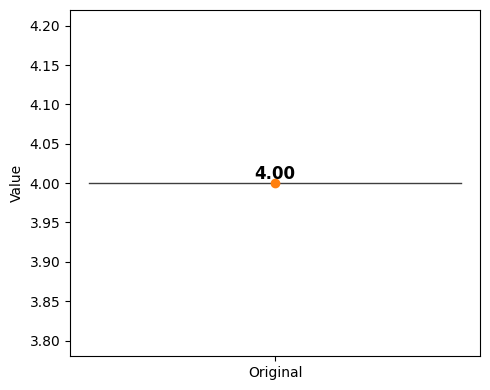

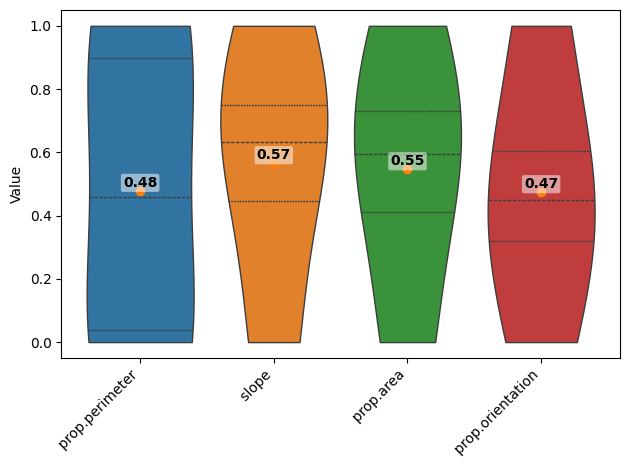

In [68]:
from sklearn.preprocessing import MinMaxScaler


dffeaturesall = dffeaturesreal


vp = violinplt(featurescounted[["Original"]], figsize=(5, 4))


scaler = MinMaxScaler()
columnstonormalize = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
dffeaturesall_norm = dffeaturesall[columnstonormalize]
dffeaturesall_norm[columnstonormalize] = scaler.fit_transform(dffeaturesall_norm)
fig = violinplt(
    dffeaturesall_norm[
        [
            " prop.perimeter",
            " slope",
            " prop.area",
            " prop.orientation",
        ]
    ],
    figsize=None,
)
# fig.savefig("violins.png", bbox_inches="tight")